In [1]:
# Styling notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("rise.css", "r").read()
    return HTML(styles)
css_styling()

<div style="font-size:2em; text-align:center; margin-top:30px; margin-bottom:20px">Data Science Academy 7</div>
<hr>
<br>

<div style="font-size:3em; text-align:center; margin-bottom:30px; color:#00746E"><b>Multivariate Forecasting :
    ARIMA-x SARIMA-x </b>
</div>

**CONTENT**

- <a href='#1'>1. Time Series Forecasting</a>
    - <a href='#1.1'>1.1 SARIMAX preparation</a>
    - <a href='#2.2'>2.2 SARIMAX forecast</a>
    - <a href='#2.3'>2.3 ML forecast</a>
- <a href='#3'>3. Landings analysis</a>

In [4]:
# Load dataset
df = pd.read_csv('../input/demand_store_forecast/train.csv')
buf = df[(df['store'] == 1) & (df['item'] == 1)].copy() # item 1 in store 5
buf = buf.set_index('date')
buf.index = pd.DatetimeIndex(buf.index).to_period('D')
y = buf['sales']
# y_to_train = y.iloc[:(len(y)-365)]
# y_to_test = y.iloc[(len(y)-365):] # last year for testing

## <a href='1'>1. Time Series Forecasting</a>

The plot below shows the sales of Item 1 in the store. 

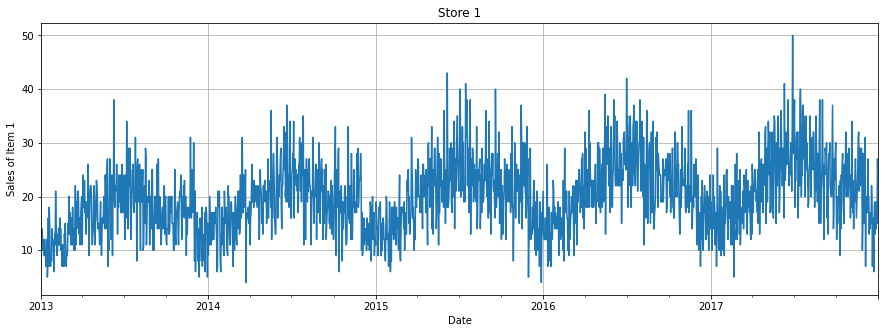

In [5]:
f, ax1 = plt.subplots(1,1,figsize=(15,5))
y.plot(ax=ax1)
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales of Item 1")
ax1.set_title ("Store 1")
plt.grid(True)

## Train test Split

In [6]:
#train_test_split
tr_start,tr_end = '2014-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
tra = buf['sales'][tr_start:tr_end].dropna()
tes = buf['sales'][te_start:te_end].dropna()

The Augmented Dickey-Fuller test can be used to test for stationarity of our time series. The null hypothesis of the test is that the <u>time series is not stationary</u> (has some time-dependent structure).

<font color= '#bfd730'> Null Hypothesis (H0): if failed to be rejected (high p-value) means it is non-stationary

Null Hypothesis (H1): if H0 is rejected (low p-value) means it is stationary</font>

In [7]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(buf['sales']['2015-01-01':].dropna(), regression = 'ct')
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

ADF Statistic: -2.071410
p-value: 0.562064


No surprise. P-value is 0.56 (we don't reject H0) - time series is <u>not stationary</u>. 

To better understand the time series behaviour I will decompose it into <font color='#20419b'>trend, seasonality and residuals.</font>

What is adfuller method parameter 'regression'?

* ’c’ : constant only (default) 
* ’ct’ : constant and trend
* ’ctt’ : constant, and linear and quadratic trend
* ’nc’ : no constant, no trend

## Correlograms
Autocorrelogram & Partial Auto-correlogram is useful that to estimate each models parameters.

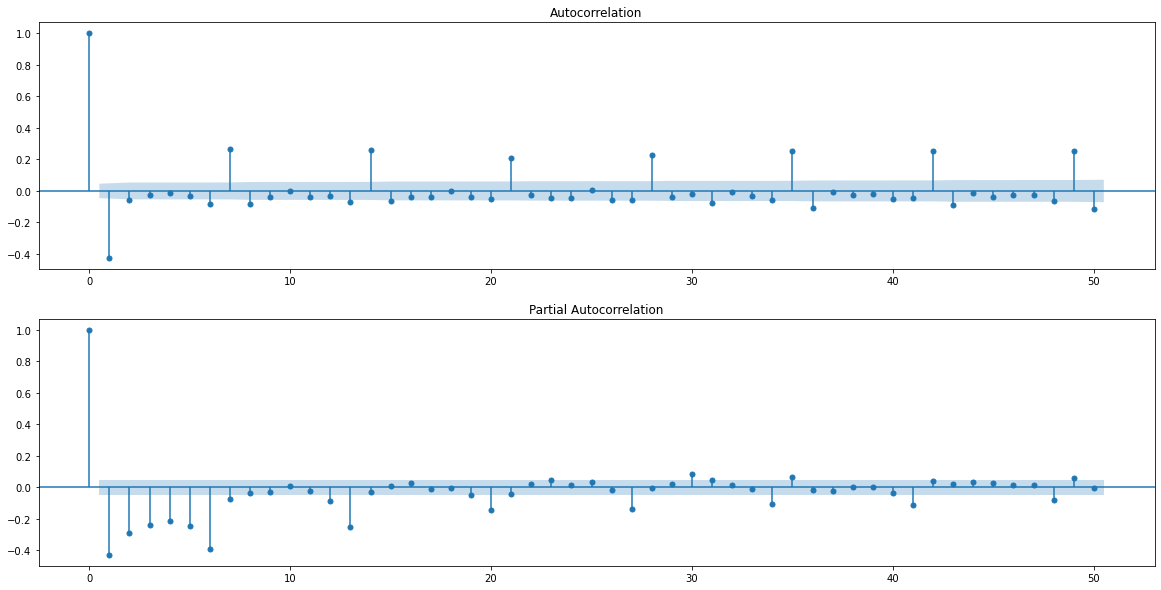

In [8]:
#we use tra.diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(y.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y.diff().dropna(), lags=50, ax=ax[1])
plt.show()

From the ACF and PACF, we will use the lag number  for ARIMA (p = 2,  d= 1, q= ?). Alternatively, we can use : `arma_order_select_ic` method, it is very easy to search best parameters(p,q) of ARMA model.

In [9]:
resDiff = sm.tsa.arma_order_select_ic(tra, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (7, 7) is the best.


## SARIMA model


### Seasonal Elements
There are four seasonal elements that are not part of ARIMA that must be configured; they are:

P: Seasonal autoregressive order <br>
D: Seasonal difference order <br>
Q: Seasonal moving average order <br>
m: The number of time steps for a single seasonal period.
* 1 for yearly
* 4 for quarterly
* 12 for monthly
* 52 for weekly
* 365 for daily

In [10]:
# For now,we choose period 1.
sarima = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),seasonal_order=(1,1,1,12),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                sales   No. Observations:                 1369
Model:             SARIMAX(7, 1, 7)x(1, 1, [1], 12)   Log Likelihood               -4044.417
Date:                              Fri, 12 Mar 2021   AIC                           8122.835
Time:                                      16:51:17   BIC                           8211.191
Sample:                                  01-01-2014   HQIC                          8155.941
                                       - 09-30-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7976      0.083     -9.636      0.000      -0.960      -0.635
ar.L2         -0.8788      0.052    -16.981      0.000      -0.980      -0.777
ar.L3         -0.8403      0.074    -11.307      0.000      -0.986      -0.695
ar.L4         -0.8027      0.067    -12.013      0.000      -0.934      -0.672
ar.L5         -0.8765      0.054    -16.289      0.000      -0.982      -0.771
ar.L6         -0.7665      0.078     -9.880      0.000      -0.919      -0.614
ar.L7          0.0950      0.042      2.260      0.024       0.013       0.177
ma.L1         -0.0727      0.081     -0.896      0.370      -0.232       0.086
ma.L2          0.1809      0.063      2.882      0.004       0.058       0.304
ma.L3         -0.0125      0.063     -0.198      0.843      -0.136       0.111
ma.L4         -0.0191      0.053     -0.359      0.719      -0.123       0.085
ma.L5          0.2076      0.055      3.743      0.000       0.099       0.316
ma.L6         -0.0686      0.065     -1.056      0.291      -0.196       0.059
ma.L7         -0.6591      0.061    -10.753      0.000      -0.779      -0.539
ar.S.L12      -0.0122      0.014     -0.868      0.386      -0.040       0.015
ma.S.L12      -1.0071      0.035    -28.531      0.000      -1.076      -0.938
sigma2        24.5679      1.380     17.799      0.000      21.863      27.273
===================================================================================
Ljung-Box (L1) (Q):                   1.65   Jarque-Bera (JB):                 6.68
Prob(Q):                              0.20   Prob(JB):                         0.04
Heteroskedasticity (H):               1.30   Skew:                             0.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

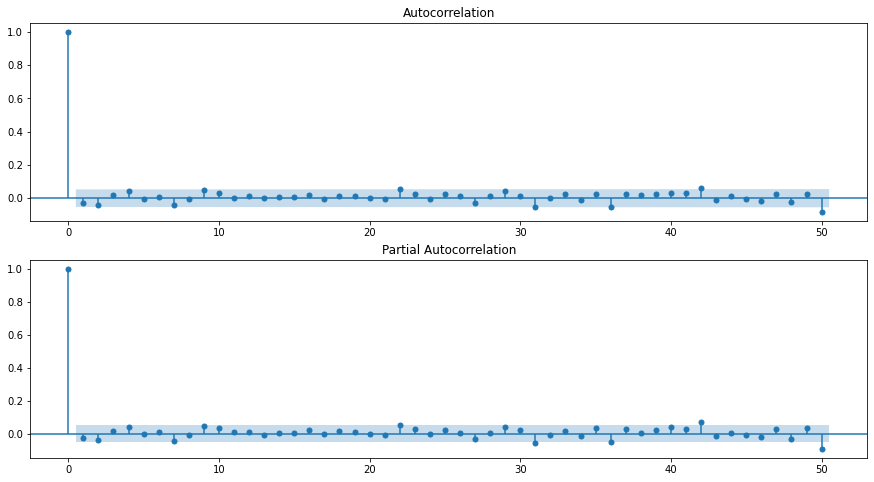

In [11]:
res = sarima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error
pred = sarima.predict(tr_end,te_end)[1:]
print('SARIMA model MSE: {}'.format(round(mean_squared_error(tes,pred),2)))

SARIMA model MSE: 49.23


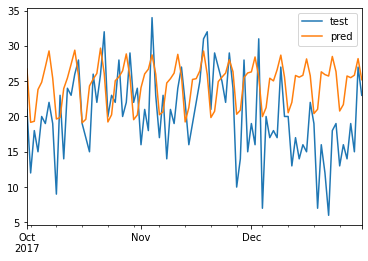

In [13]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

## Multivariate Forecasting
Added exogenous variable to ARIMA & SARIMA

### Make features1
Let's try to make some features.

* month
* dayofweek
* sales_shifted_364(1year_shift)
* sales_shifted_728(2year_shift)


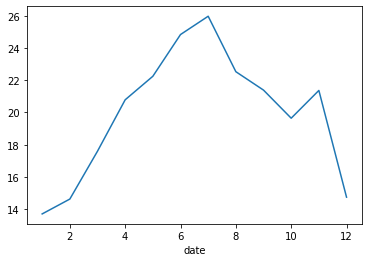

In [14]:
# Sales groupby month
buf.groupby(buf.index.month).sales.mean().plot();plt.show()

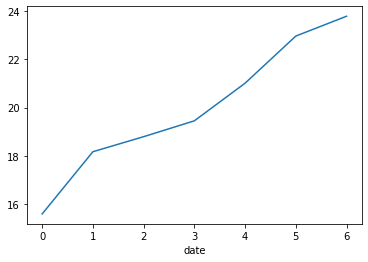

In [15]:
# Sales groupby day of week
buf.groupby(buf.index.weekday).sales.mean().plot();plt.show()

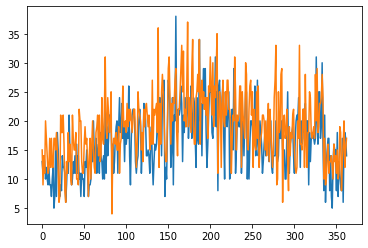

In [16]:
plt.plot(buf[0:363].sales.dropna().values)
plt.plot(buf[364:727].sales.dropna().values);plt.show()

Feature Creating with Day of week and Month

In [17]:
buf = df[(df.item==1)&(df.store==1)].copy()#reset buf
buf = buf.set_index('date')
buf.index = pd.DatetimeIndex(buf.index).to_period('D')
#month one hot encoding
buf['month'] = buf.index.month
month_dummies = pd.get_dummies(buf['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]
buf = pd.concat([buf, month_dummies], axis=1).drop(['month'],axis=1)
#dayofweek one hot encoding
buf['dayofweek'] = buf.index.weekday
week_dummies = pd.get_dummies(buf['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
buf = pd.concat([buf, week_dummies], axis=1).drop(['dayofweek'],axis=1)
#Satday,Sunday
buf['weekend'] = (buf.index.dayofweek>4).astype(int)#Saturday,Sunday
#Sunday
#buf['sunday'] = (buf.index.dayofweek==6).astype(int)#Saturday,Sunday

In [18]:
buf.columns

Index(['store', 'item', 'sales', 'month-1', 'month-2', 'month-3', 'month-4',
       'month-5', 'month-6', 'month-7', 'month-8', 'month-9', 'month-10',
       'month-11', 'month-12', 'dayofweek-0', 'dayofweek-1', 'dayofweek-2',
       'dayofweek-3', 'dayofweek-4', 'dayofweek-5', 'dayofweek-6', 'weekend'],
      dtype='object')

In [19]:
#shifted data
#buf['sales_shifted_91'] = buf.sales.shift(91)
buf['sales_shifted_728'] = buf.sales.shift(728)
buf['sales_shifted_364'] = buf.sales.shift(364)

In [20]:
buf[['sales_shifted_728','sales_shifted_364']].head(-200)

,sales_shifted_728,sales_shifted_364
date,,
2013-01-01,NaN,NaN
2013-01-02,NaN,NaN
2013-01-03,NaN,NaN
2013-01-04,NaN,NaN
2013-01-05,NaN,NaN
...,...,...
2017-06-10,28.0,31.0
2017-06-11,30.0,22.0
2017-06-12,19.0,22.0


In [21]:
buf[['sales_shifted_728','sales_shifted_364']].tail()

,sales_shifted_728,sales_shifted_364
date,,
2017-12-27,15.0,16.0
2017-12-28,18.0,21.0
2017-12-29,21.0,24.0
2017-12-30,13.0,14.0
2017-12-31,12.0,19.0


### Split Train Test for ARIMAX model

In [22]:
tr_start,tr_end = '2015-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
tra = buf['sales'][tr_start:tr_end].dropna()
tes = buf['sales'][te_start:te_end].dropna()
exog_train = buf.drop(['store','item','sales'],axis = 1)[tr_start:tr_end].dropna()
exog_test = buf.drop(['store','item','sales'],axis = 1)[te_start:te_end].dropna()

In [23]:
exog_train.head()

,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,...,dayofweek-0,dayofweek-1,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6,weekend,sales_shifted_728,sales_shifted_364
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,14.0,14.0
2015-01-02,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,13.0,11.0
2015-01-03,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,10.0,20.0
2015-01-04,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,12.0,17.0
2015-01-05,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,10.0,14.0


## ARIMAX Model

In [24]:
arimax = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),seasonal_order=(0,0,0,0),exog = exog_train,freq='D',
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
arimax.summary()
#We can use SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0) .

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1004
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -2958.786
Date:                Fri, 12 Mar 2021   AIC                           5991.571
Time:                        16:51:27   BIC                           6172.973
Sample:                    01-01-2015   HQIC                          6060.533
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
month-1              -3.6785      1.113     -3.306      0.001      -5.860      -1.497
month-2              -3.4749      1.065     -3.263      0.001      -5.562      -1.388
month-3              -1.9680      0.979     -2.010      0.044      -3.887      -0.049
month-4              -0.5476      0.875     -0.626      0.532      -2.263       1.168
month-5               0.1689      0.936      0.180      0.857      -1.665       2.003
month-6               1.3382      0.980      1.366      0.172      -0.582       3.259
month-7               2.9408      1.042      2.821      0.005       0.898       4.984
month-8               1.3878      0.927      1.496      0.135      -0.430       3.206
month-9               3.0737      0.881      3.490      0.000       1.347       4.800
month-10              2.8295      1.046      2.706      0.007       0.780       4.879
month-11              1.9694      1.105      1.782      0.075      -0.197       4.136
month-12             -4.0394      1.094     -3.691      0.000      -6.184      -1.894
dayofweek-0          -3.5715      0.444     -8.048      0.000      -4.441      -2.702
dayofweek-1          -0.6681      0.397     -1.682      0.093      -1.447       0.111
dayofweek-2          -0.3423      0.359     -0.953      0.341      -1.046       0.362
dayofweek-3           0.2048      0.385      0.531      0.595      -0.551       0.960
dayofweek-4           1.7000      0.364      4.675      0.000       0.987       2.413
dayofweek-5           0.9990      0.290      3.441      0.001       0.430       1.568
dayofweek-6           1.6780      0.316      5.314      0.000       1.059       2.297
weekend               2.6769      0.227     11.775      0.000       2.231       3.123
sales_shifted_728     0.0524      0.034      1.519      0.129      -0.015       0.120
sales_shifted_364     0.0710      0.033      2.163      0.031       0.007       0.135
ar.L1                -0.2542      3.720     -0.068      0.946      -7.546       7.037
ar.L2                 0.7190      0.783      0.919      0.358      -0.815       2.253
ar.L3                -0.0430      2.301     -0.019      0.985      -4.553       4.467
ar.L4                -0.3458      0.963     -0.359      0.719      -2.232       1.541
ar.L5                 0.1477      0.809      0.183      0.855      -1.437       1.732
ar.L6                 0.0532      0.906      0.059      0.953      -1.723       1.829
ar.L7                -0.0261      0.169     -0.154      0.878      -0.358       0.306
ma.L1                -0.9078      3.659     -0.248      0.804      -8.080       6.264
ma.L2                -1.0062      4.329     -0.232      0.816      -9.491       7.478
ma.L3                 0.8755      2.350      0.373      0.709      -3.730       5.481
ma.L4                 0.3167      3.091      0.102      0.918      -5.742       6.375
ma.L5                -0.4929      1.217     -0.405      0.685      -2.878       1.892
ma.L6                 0.0537      1.308      0.041      0.9

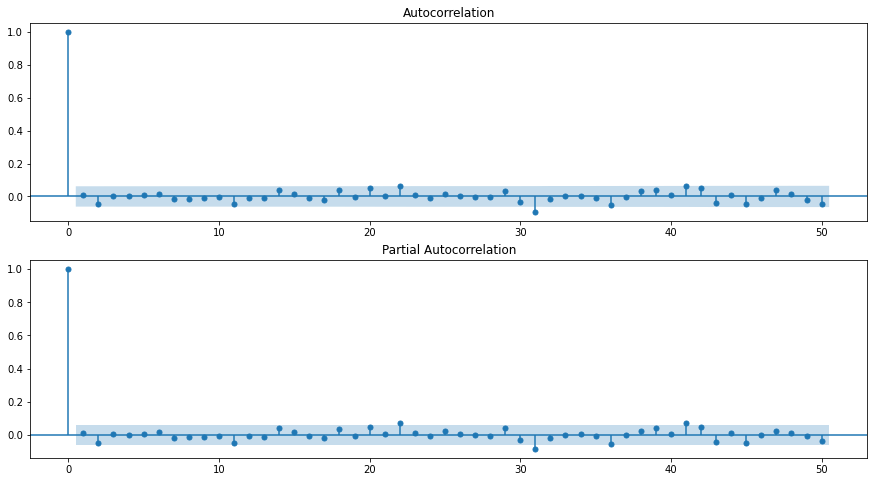

In [25]:
res = arimax.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error
pred = arimax.predict(tr_end,te_end,exog = exog_test)[1:]
print('ARIMAX model MSE:{}'.format(round(mean_squared_error(tes,pred),3)))

ARIMAX model MSE:23.601


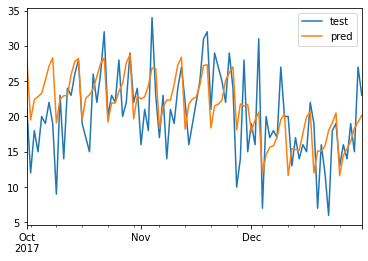

In [27]:
# Visualise the ARIMA-x forecasts actual vs predicted. 
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

Diagnostics of residual
* Lack of correlation. If residuals are correlated, means there are some information left in the residuals. 
    *    <i> Todo: check ACF Plot, Box-Pierce test
* Normality. Non-zero mean for residuals, means forecast are biased. Residuals have constant variance. 

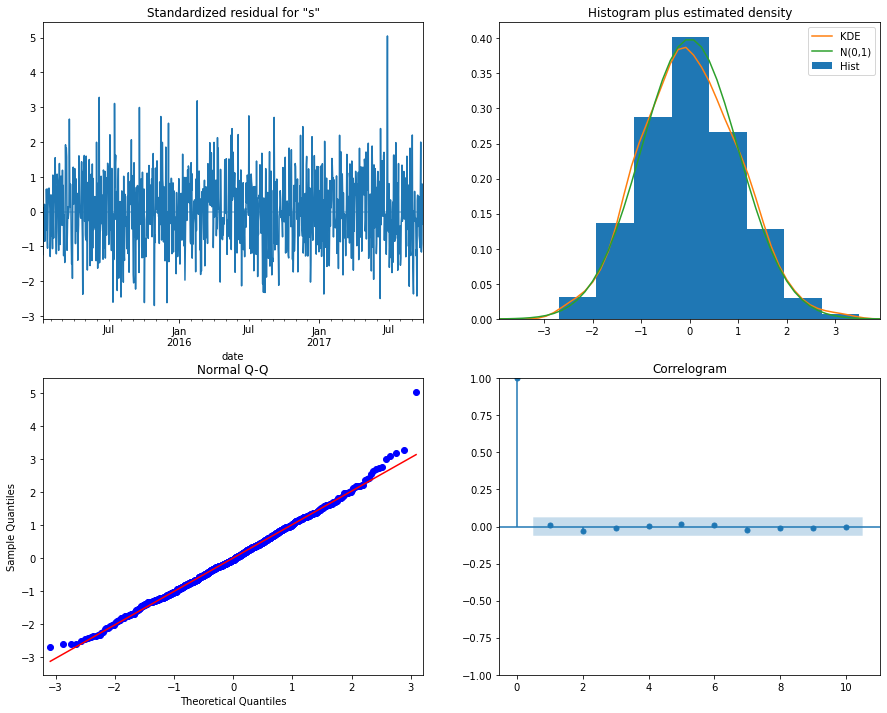

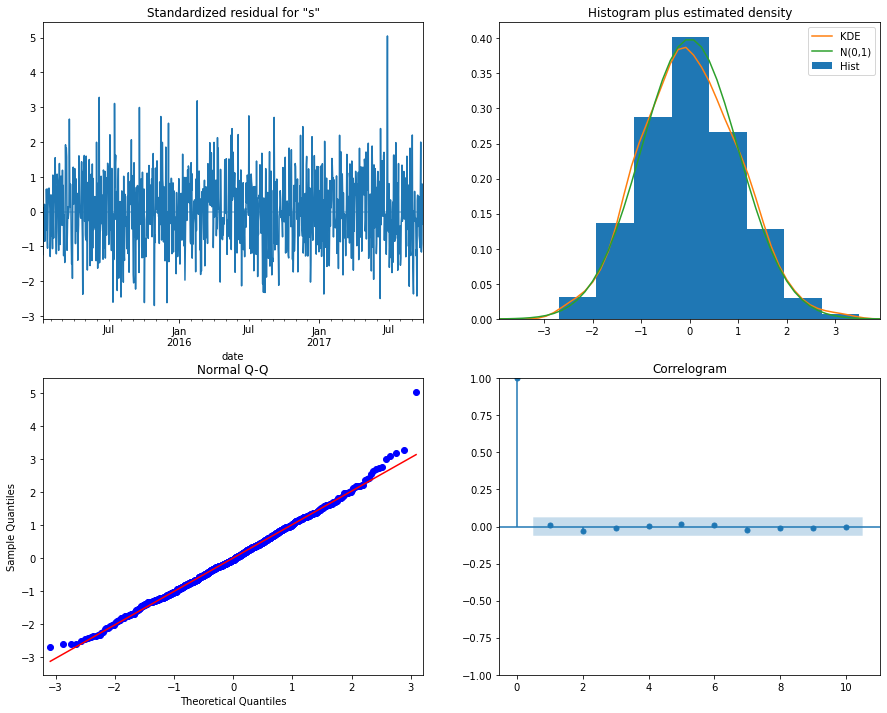

In [28]:
# Visualisation of Residuals Analysis of ARIMAX model
arimax.plot_diagnostics(figsize=(15, 12))

## SARIMAX Model

In [29]:
sarimax = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),seasonal_order=(1,1,1,12),exog = exog_train,
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                sales   No. Observations:                 1004
Model:             SARIMAX(7, 1, 7)x(1, 1, [1], 12)   Log Likelihood               -2955.081
Date:                              Fri, 12 Mar 2021   AIC                           5988.163
Time:                                      16:52:12   BIC                           6178.417
Sample:                                  01-01-2015   HQIC                          6060.576
                                       - 09-30-2017                                         
Covariance Type:                                opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
month-1              -5.2250      1.712     -3.051      0.002      -8.581      -1.869
month-2              -2.2237      1.818     -1.223      0.221      -5.787       1.340
month-3              -2.1218      1.795     -1.182      0.237      -5.640       1.397
month-4               1.9795      1.660      1.192      0.233      -1.274       5.233
month-5               0.2071      1.531      0.135      0.892      -2.794       3.208
month-6               4.0451      1.500      2.697      0.007       1.105       6.985
month-7               6.7121      1.512      4.439      0.000       3.749       9.676
month-8               3.4732      1.507      2.305      0.021       0.520       6.427
month-9               6.6812      1.553      4.303      0.000       3.638       9.724
month-10              2.5656      1.587      1.616      0.106      -0.545       5.676
month-11             -5.3276      1.602     -3.325      0.001      -8.468      -2.188
month-12            -10.7655      1.707     -6.307      0.000     -14.111      -7.420
dayofweek-0          -3.6901      0.469     -7.870      0.000      -4.609      -2.771
dayofweek-1          -0.7709      0.366     -2.103      0.035      -1.489      -0.053
dayofweek-2          -0.3099      0.372     -0.834      0.404      -1.038       0.418
dayofweek-3           0.2193      0.365      0.601      0.548      -0.495       0.934
dayofweek-4           1.7574      0.390      4.503      0.000       0.992       2.522
dayofweek-5           1.0455      0.278      3.767      0.000       0.502       1.589
dayofweek-6           1.7485      0.295      5.925      0.000       1.170       2.327
weekend               2.7940      0.247     11.332      0.000       2.311       3.277
sales_shifted_728    -0.0270      0.038     -0.715      0.475      -0.101       0.047
sales_shifted_364     0.0355      0.037      0.972      0.331      -0.036       0.107
ar.L1                -1.0657      0.604     -1.764      0.078      -2.250       0.118
ar.L2                -0.9109      1.117     -0.816      0.415      -3.099       1.277
ar.L3                -0.3969      1.342     -0.296      0.767      -3.027       2.234
ar.L4                -0.1689      1.123     -0.150      0.880      -2.370       2.032
ar.L5                -0.1302      0.723     -0.180      0.857      -1.546       1.286
ar.L6                -0.5242      0.380     -1.380      0.168      -1.269       0.220
ar.L7                 0.0234      0.062      0.380      0.704      -0.098       0.144
ma.L1                 0.2117      0.600      0.353      0.724      -0.964       1.388
ma.L2                -0.0465      0.639     -0.073      0.942      -1.299       1.206
ma.L3                -0.4163      0.458     -0.908      0.364      -1.315       0.482
ma.L4                -0.1729      0.406     -0.425      0.671      -0.969       0.624
ma.L5              

Summary explanations:

1. **Ljung-Box (Q)** - This test is used to check for the *lack of fit* of a time series model. The null hypothesis here is there are no correlations in the residuals. In our case we reject the null hypothesis what means that residuals are somehow correlated.

2. **Jarque-Bera (JB)** - This is a test for normality of distributon. It is basing on values of skewness and kurtosis where for the normal distibution these values should be respectively 0 and 3. The null hypothesis of the test is that the sample comes from the normal distribution. Ander this hypothesis the chi-squared distribution with 2 degrees of freedom can be used. In our case JB statistics is 8.76 which gives probability of 0.01 - meaning that we don't reject the null hypothesis.

3. **Heteroskedasticity (H)** - Checks if the variance is constant


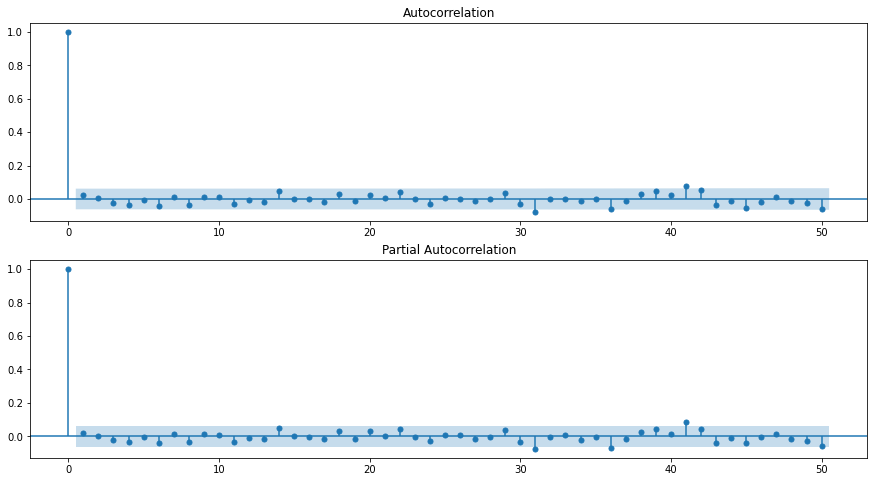

In [30]:
res = sarimax.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error
pred = sarimax.predict(tr_end,te_end,exog = exog_test)[1:]
print('SARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))

SARIMAX model MSE:86.72614798163212


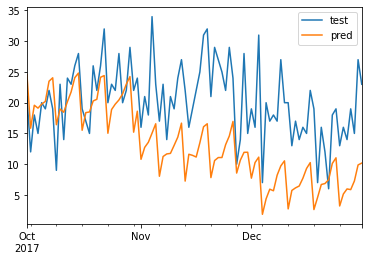

In [32]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

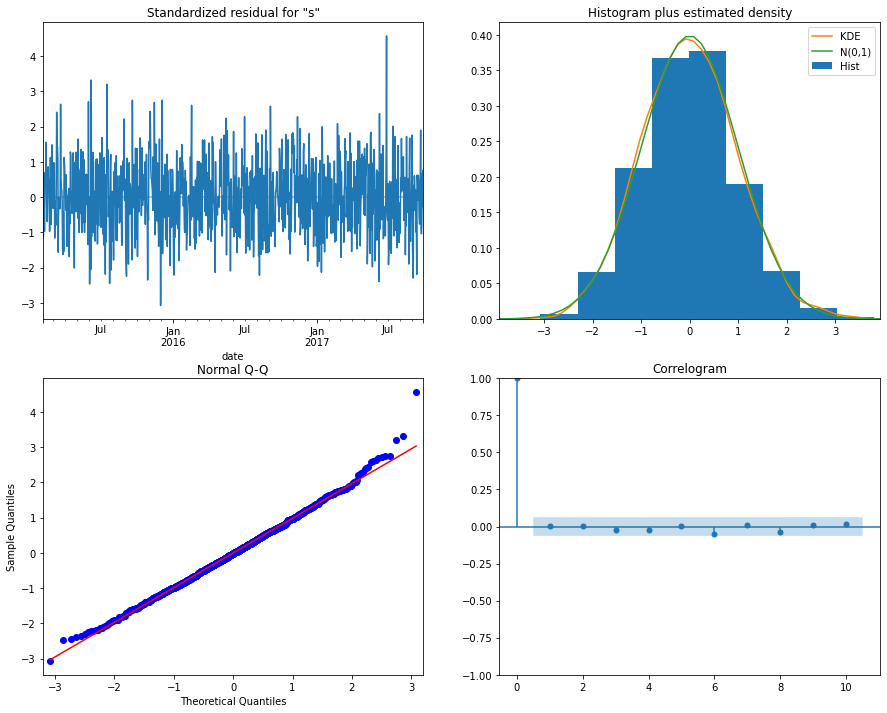

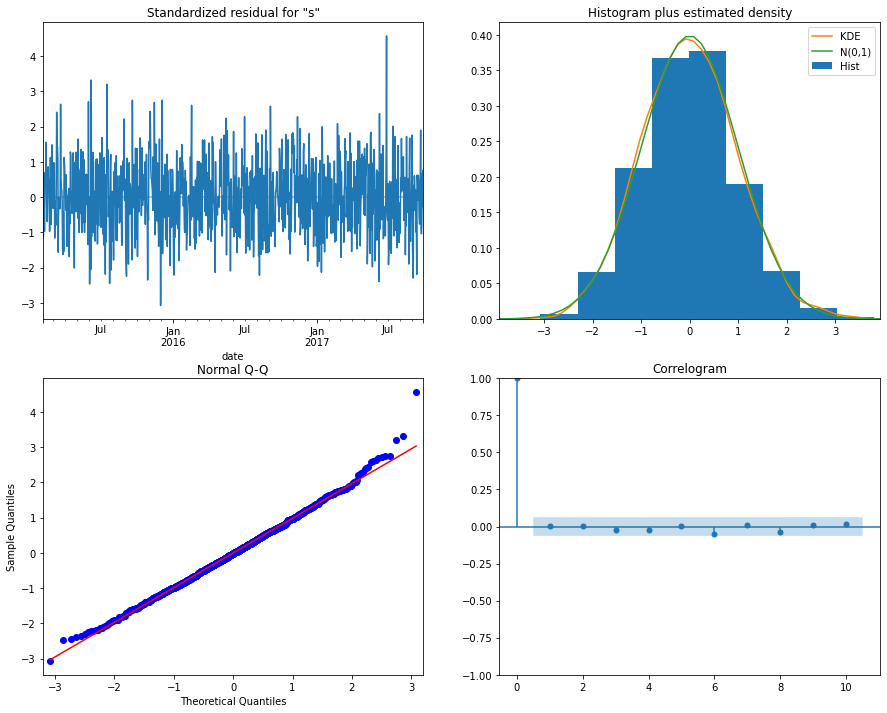

In [33]:
sarimax.plot_diagnostics(figsize=(15, 12))

It seems that ARIMAX model's prediction is better than SARIMAX model's.
And because SARIMA(X) model has a issue(seasonal period parameter),we choose ARIMAX model.

## ARIMAX Model's summary check

The results of Jarque-Bera test and Ljung-Box test provide an indication of the validity of this model.

In this model's summary, Jarque-Bera test's Prob is under 0.05.
It means that this model's resid is not following a normal distribution.
In other words, some infomations still remain in this model's resid.

Look at the histgram which was output by plot_diagnostics method, It looks like slightly skew.

Ljung-Box test: https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test

Jarque-Bera test: https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test

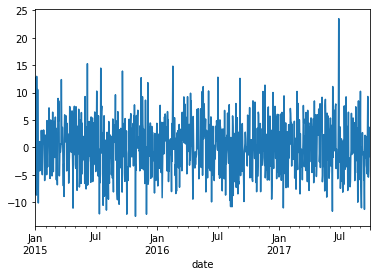

In [34]:
arimax.resid.plot();plt.show()
#It seems that there is outlier in this model's resid on late June.

In [35]:
res_df = pd.DataFrame(arimax.resid,columns=['resid'])
res_df.sort_values(by='resid',ascending=False).head(5)

,resid
date,
2017-06-28,23.504471
2015-06-06,15.290083
2016-02-17,14.827505
2015-07-16,14.475728
2015-09-19,13.939520


The outlier is the sales in '2017-06-28'.
Is the date an anniversary or something?

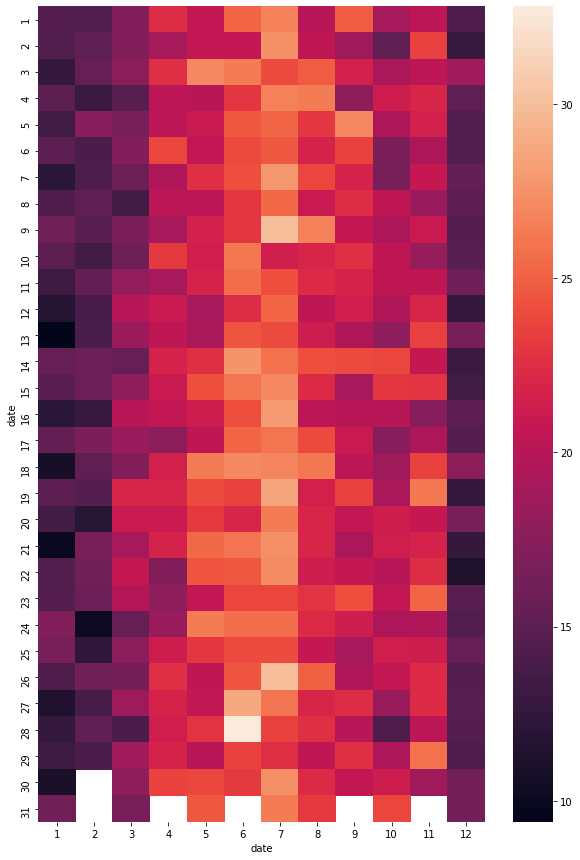

In [36]:
plt.figure(figsize=(10,15))
piv_val = buf.pivot_table(values='sales',
                          index=buf.index.day,
                          columns=buf.index.month,
                          aggfunc='mean')
sns.heatmap(piv_val)
plt.show()

In [37]:
buf[(buf.index.day == 28)&(buf.index.month == 6)]['sales']

date
2013-06-28    17
2014-06-28    34
2015-06-28    35
2016-06-28    28
2017-06-28    50
Freq: D, Name: sales, dtype: int64

28th June 2017's sales is too big as other 28th June sales!
Besides, that one day is a weekday.

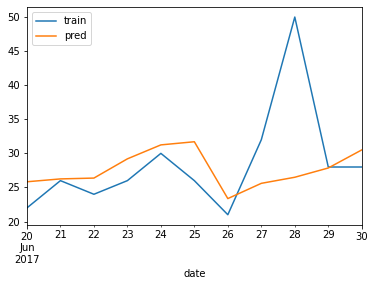

In [38]:
#train data predict
pred = arimax.predict(tr_start,tr_end,exog = exog_train)[1:]
pd.DataFrame({'train':tra['2017-06-20':'2017-06-30'],
              'pred':pred['2017-06-20':'2017-06-30']}).plot();plt.show()

### Make Features 2

In [39]:
#outlier etc...
buf['outlier_flag']=0
buf.loc[buf.index == '2017-06-28','outlier_flag']=1

In [40]:
tr_start,tr_end = '2015-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
tra = buf['sales'][tr_start:tr_end].dropna()
tes = buf['sales'][te_start:te_end].dropna()
exog_train = buf.drop(['store','item','sales'],axis = 1)[tr_start:tr_end].dropna()
exog_test = buf.drop(['store','item','sales'],axis = 1)[te_start:te_end].dropna()

Define our SARIMAX model. Main configurations are the `exog` argument.
The trend and seasonal hyperparameters are specified as `order` and `seasonal_order`. They are 3 and 4-element tuples.
Other hyperparameters can be found here. http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

### ARIMA-X Model
Set `seasonal_order` to tuple(0,0,0,0) for ARIMA-X model.

In [41]:
arimax_2 = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),seasonal_order=(0,0,0,0),exog = exog_train,
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
arimax_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1004
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -2942.168
Date:                Fri, 12 Mar 2021   AIC                           5960.337
Time:                        16:52:23   BIC                           6146.641
Sample:                    01-01-2015   HQIC                          6031.163
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
month-1              -4.3158      1.076     -4.012      0.000      -6.424      -2.207
month-2              -3.4280      1.046     -3.276      0.001      -5.479      -1.377
month-3              -2.5223      0.927     -2.720      0.007      -4.340      -0.705
month-4              -0.1289      0.830     -0.155      0.877      -1.756       1.498
month-5               0.4223      0.906      0.466      0.641      -1.354       2.198
month-6               1.6372      0.976      1.677      0.094      -0.276       3.551
month-7               3.6109      1.025      3.524      0.000       1.603       5.619
month-8               1.5339      0.906      1.694      0.090      -0.241       3.309
month-9               2.7009      0.827      3.265      0.001       1.080       4.322
month-10              2.1488      0.981      2.190      0.028       0.226       4.072
month-11              2.2981      1.066      2.156      0.031       0.209       4.388
month-12             -3.9572      1.077     -3.676      0.000      -6.067      -1.847
dayofweek-0          -3.5301      0.448     -7.874      0.000      -4.409      -2.651
dayofweek-1          -1.1510      0.396     -2.907      0.004      -1.927      -0.375
dayofweek-2          -0.4755      0.376     -1.265      0.206      -1.212       0.261
dayofweek-3           0.1362      0.380      0.359      0.720      -0.608       0.881
dayofweek-4           1.9146      0.368      5.196      0.000       1.192       2.637
dayofweek-5           1.4126      0.287      4.923      0.000       0.850       1.975
dayofweek-6           1.6929      0.315      5.367      0.000       1.075       2.311
weekend               3.1056      0.231     13.472      0.000       2.654       3.557
sales_shifted_728     0.0208      0.035      0.593      0.553      -0.048       0.090
sales_shifted_364     0.0431      0.034      1.279      0.201      -0.023       0.109
outlier_flag         20.5118      6.253      3.280      0.001       8.257      32.767
ar.L1                -0.5476      1.026     -0.534      0.594      -2.559       1.463
ar.L2                 0.2548      0.959      0.266      0.790      -1.625       2.135
ar.L3                 0.1984      0.924      0.215      0.830      -1.613       2.010
ar.L4                 0.1134      0.636      0.178      0.859      -1.134       1.361
ar.L5                -0.1551      0.481     -0.323      0.747      -1.098       0.788
ar.L6                -0.3441      0.376     -0.914      0.360      -1.082       0.393
ar.L7                -0.0303      0.075     -0.404      0.686      -0.177       0.117
ma.L1                -0.4141      1.025     -0.404      0.686      -2.422       1.594
ma.L2                -0.8021      0.878     -0.914      0.361      -2.523       0.919
ma.L3                 0.0379      0.830      0.046      0.964      -1.590       1.666
ma.L4                 0.0872      0.676      0.129      0.897      -1.237       1.411
ma.L5                 0.3357      0.646      0.520      0.6

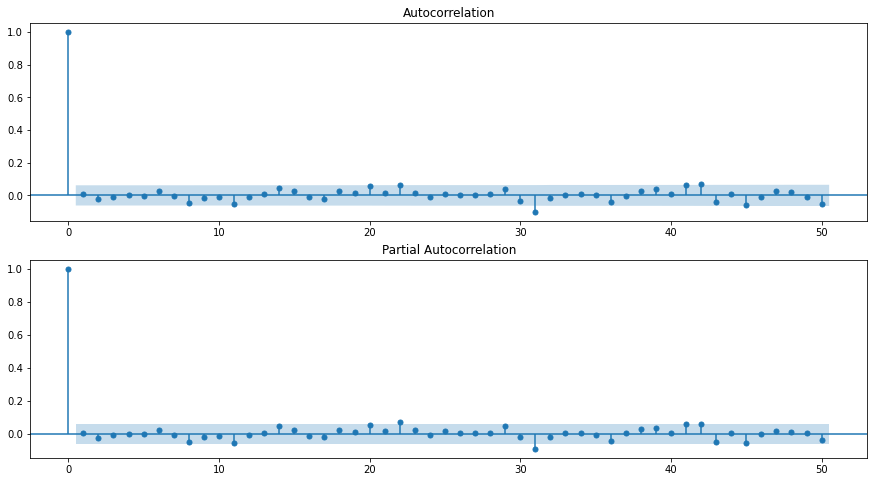

In [42]:
res = arimax_2.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error
pred = arimax_2.predict(tr_end,te_end,exog = exog_test)[1:]
print('ARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))

ARIMAX model MSE:24.088721494528198


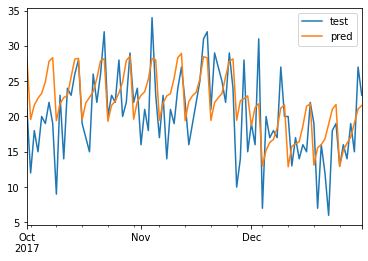

In [44]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

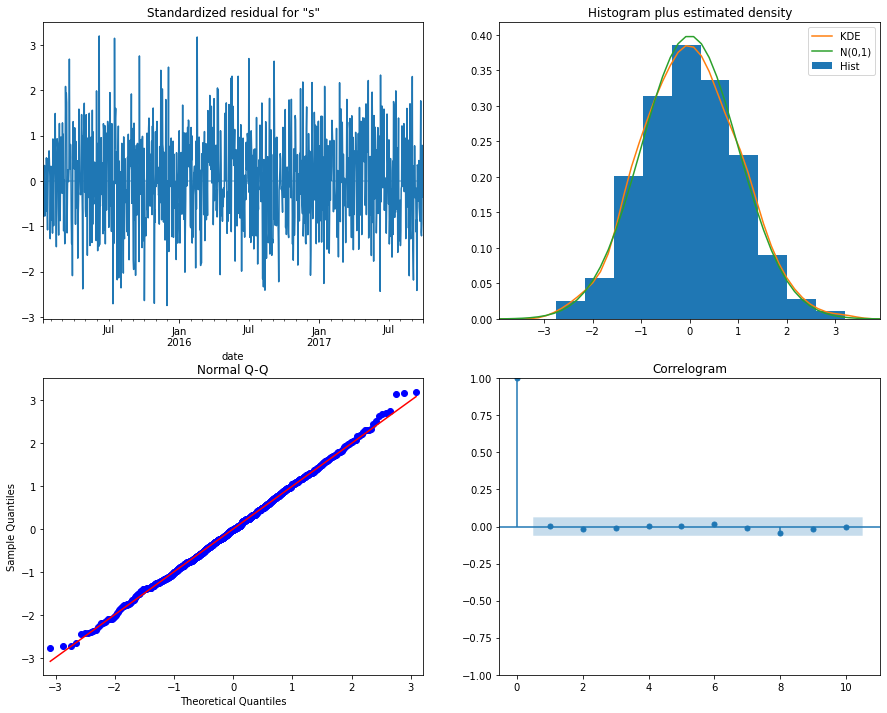

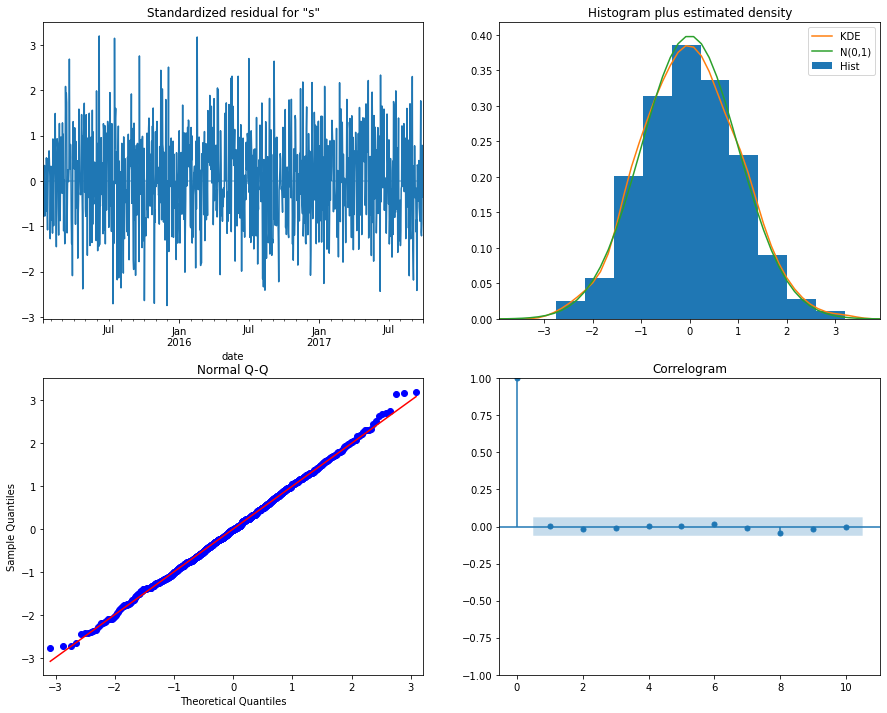

In [45]:
arimax_2.plot_diagnostics(figsize=(15, 12))

The histgram looks like still skew, but Jarque-Bera test's Prob is over 0.05.
It means that this model's resid is following a normal distribution.

An added featrue was useless to grow up predict accuracy.
but, we were able to make a better model.

### Search best parameters
We can do grid search on the best parameters for SARIMAX. 

<font color = 'red'>Be careful as this will take some time to run! </font>

In [ ]:
import itertools
from sklearn.metrics import mean_squared_error

p = q = range(1,3)
pdq = list(itertools.product(p, [1], q))
sp = sq = range(1,8)#range(0,1) <- ARIMAX
seasonal_pdq = list(itertools.product(sp, [0,1], sq,[12]))#rlist(itertools.product(sp, [0], sq,[0]))<- ARIMAX

params = []
params_s = []
aics = []
mses = []
cnt = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:

        try:
            mod = sm.tsa.statespace.SARIMAX(tra,
                                            order=param,
                                            exog = exog_train,
                                            seasonal_order=param_seasonal,
                                            freq='D',
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            pred = results.get_prediction(start = pd.to_datetime(tr_end),
                                      end = pd.to_datetime(te_end),exog=exog_test)

            params.append(param)
            params_s.append(param_seasonal)
            aics.append(results.aic)
            mses.append(mean_squared_error(tes,pred.predicted_mean[1:]))


            #if cnt % 8 == 0:
            print('SARIMAX{}x{} - AIC:{} - MSE:{}'.format(param,
                                                            param_seasonal,
                                                            results.aic,
                                                        mses[-1]))
                #cnt += 1

        except:
            continue

min_ind = aics.index(min(aics))
bestparam = (params[min_ind],params_s[min_ind])
print('best_param_aic:',bestparam,' aic:',min(aics))
min_ind = mses.index(min(mses))
bestparam = (params[min_ind],params_s[min_ind])
print('best_param_mse:',bestparam,' mse:',min(mses))

print('Finish!!')

SARIMAX(1, 1, 1)x(1, 0, 1, 12) - AIC:5900.131449626644 - MSE:27.640177803100325
SARIMAX(1, 1, 1)x(1, 0, 2, 12) - AIC:5842.347043380084 - MSE:26.12948579122236
SARIMAX(1, 1, 1)x(1, 0, 3, 12) - AIC:5769.03265908223 - MSE:27.23495826470104
SARIMAX(1, 1, 1)x(1, 0, 4, 12) - AIC:5700.987278708296 - MSE:26.875834107424325
SARIMAX(1, 1, 1)x(1, 0, 5, 12) - AIC:5643.08300199378 - MSE:27.128488343900695
SARIMAX(1, 1, 1)x(1, 0, 6, 12) - AIC:5565.231794404597 - MSE:27.083217572356087
SARIMAX(1, 1, 1)x(1, 0, 7, 12) - AIC:5503.781847419072 - MSE:24.835549325662488
SARIMAX(1, 1, 1)x(1, 1, 1, 12) - AIC:5908.6298711712625 - MSE:37.31838921702025
SARIMAX(1, 1, 1)x(1, 1, 2, 12) - AIC:5816.816917034059 - MSE:21.809863354865275
